In [42]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output

from collections import defaultdict

In [78]:
from helper_data import get_dataloaders_cifar10

train_loader, val_loader, test_loader = get_dataloaders_cifar10(batch_size=4, val_fraction=0.2)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


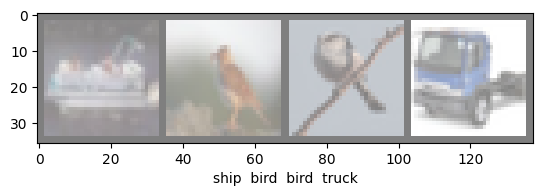

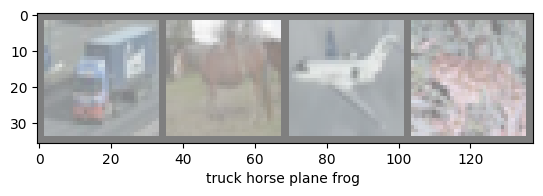

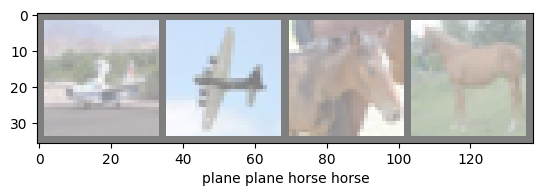

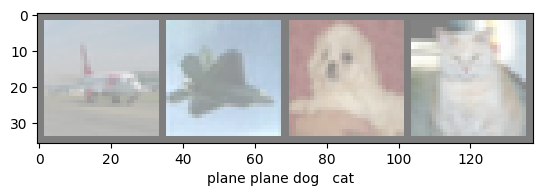

In [79]:
def imshow(img, xlabel=None):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if xlabel:
        plt.xlabel(xlabel)
    plt.show()

dataiter = iter(train_loader)

for i in range(4):
    images, labels = next(dataiter)
    xlabel = ' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size))
    imshow(torchvision.utils.make_grid(images), xlabel)

In [80]:
class BaselineNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [81]:
def plot_losses(train_losses, train_metrics, val_losses, val_metrics):
    '''
    Plot losses and metrics while training
      - train_losses: sequence of train losses
      - train_metrics: sequence of train MSE values
      - val_losses: sequence of validation losses
      - val_metrics: sequence of validation MSE values
    '''
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(val_losses) + 1), val_losses, label='val')
    axs[1].plot(range(1, len(train_metrics) + 1), train_metrics, label='train')
    axs[1].plot(range(1, len(val_metrics) + 1), val_metrics, label='val')

    if max(train_losses) / min(train_losses) > 10:
        axs[0].set_yscale('log')

    if max(train_metrics) / min(train_metrics) > 10:
        axs[0].set_yscale('log')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    axs[0].set_ylabel('loss')
    axs[1].set_ylabel('metric')
    plt.show()


def train_and_validate(model, optimizer, criterion,
                       metric, train_loader, val_loader, num_epochs, device, verbose=True):
    '''
    Train and validate neural network
      - model: neural network to train
      - optimizer: optimizer chained to a model
      - criterion: loss function class
      - metric: function to measure quality taking neural networks predictions
                 and ground truth labels
      - train_loader: DataLoader with train set
      - val_loader: DataLoader with validation set
      - num_epochs: number of epochs to train
      - verbose: whether to plot metrics during training
      - device: device to use for training; defaults to "cuda:0"
    Returns:
      - train_mse: training MSE over the last epoch
      - val_mse: validation MSE after the last epoch
    '''
    train_losses, val_losses = [], []
    train_metrics, val_metrics = [], []

    model.to(device)

    for epoch in range(1, num_epochs+1):
        model.train()
        running_loss, running_metric = 0, 0
        pbar = tqdm(train_loader, desc=f'Training {epoch}/{num_epochs}') \
            if verbose else train_loader

        for i, (X_batch, y_batch) in enumerate(pbar, 1):
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            predict = model(X_batch)

            loss = criterion(predict, y_batch)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                metric_value = metric(predict, y_batch)
                if type(metric_value) == torch.Tensor:
                    metric_value = metric_value.item()
                running_loss += loss.item() * y_batch.size(0)
                running_metric += metric_value * y_batch.size(0)

            if verbose and i % 100 == 0:
                pbar.set_postfix({'loss': loss.item(), 'metric': metric_value})

        train_losses += [running_loss / len(train_loader.dataset)]
        train_metrics += [running_metric / len(train_loader.dataset)]

        model.eval()
        running_loss, running_metric = 0, 0
        pbar = tqdm(val_loader, desc=f'Validating {epoch}/{num_epochs}') \
            if verbose else val_loader

        for i, (X_batch, y_batch) in enumerate(pbar, 1):
            with torch.no_grad():
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)

                predictions = model(X_batch)
                loss = criterion(predict, y_batch)

                metric_value = metric(predictions, y_batch)
                if type(metric_value) == torch.Tensor:
                    metric_value = metric_value.item()
                running_loss += loss.item() * y_batch.size(0)
                running_metric += metric_value * y_batch.size(0)

            if verbose and i % 100 == 0:
                pbar.set_postfix({'loss': loss.item(), 'metric': metric_value})

        val_losses += [running_loss / len(val_loader.dataset)]
        val_metrics += [running_metric / len(val_loader.dataset)]

        if verbose:
            plot_losses(train_losses, train_metrics, val_losses, val_metrics)

    return train_metrics[-1], val_metrics[-1]


def metric_accuracy(y_pred, y_true):
    '''Measure accuracy between predicted classes and target classes while training'''
    _, y_pred = torch.max(y_pred, dim=1)
    return (y_pred == y_true).sum().item() / y_true.size(0)


def test_cifar10_classifier(model, test_loader, classes, device):
    '''Test total accuracy and accuracy for each class of the model on the test data.'''
    model.eval()
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            for label, prediction in zip(labels, predicted):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1

    total_acc = 100 * sum(correct_pred.values()) / sum(total_pred.values())
    print(f'Total accuracy: {total_acc:.2f} %')

    acc_for_class = {classname: 0 for classname in classes}

    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        acc_for_class[classname] = accuracy
        print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

    return total_acc, acc_for_class

In [82]:
baseline_net = BaselineNet()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(baseline_net.parameters(), lr=0.001, momentum=0.9)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

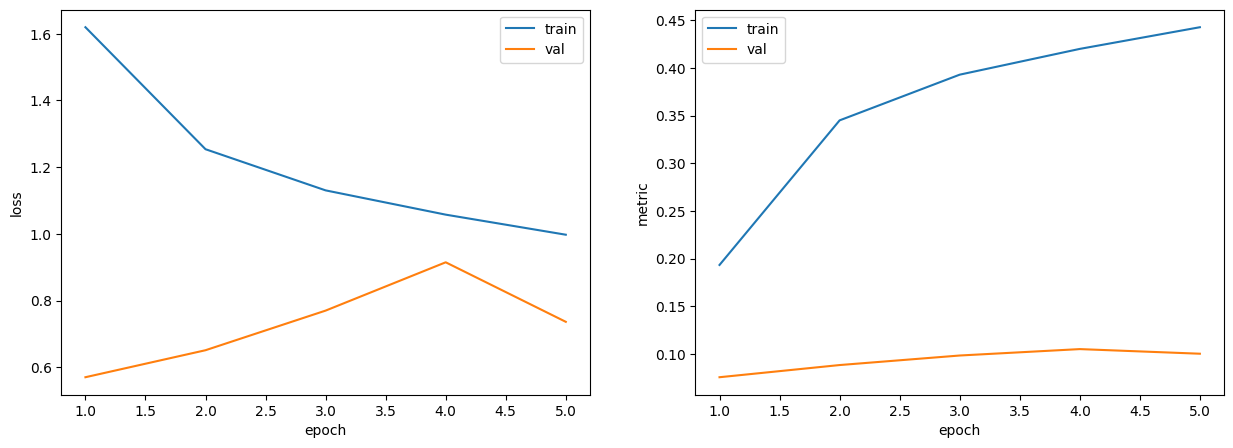

In [83]:
p = train_and_validate(
    model = baseline_net,
    optimizer = optimizer,
    criterion = criterion,
    metric = metric_accuracy,
    train_loader = train_loader,
    val_loader = val_loader,
    num_epochs = 5,
    device = device
)

In [57]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BaselineNet().to(device)
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.24
Estimated Total Size (MB): 0.31
----------------------------------------------------------------


In [70]:
baseline_acc = test_cifar10_classifier(baseline_net, test_loader, classes, device=device)

Accuracy of the network on the 10000 test images: 59.29 %
Accuracy for class: plane is 59.9 %
Accuracy for class: car   is 65.7 %
Accuracy for class: bird  is 45.5 %
Accuracy for class: cat   is 34.7 %
Accuracy for class: deer  is 40.3 %
Accuracy for class: dog   is 62.1 %
Accuracy for class: frog  is 70.1 %
Accuracy for class: horse is 63.2 %
Accuracy for class: ship  is 82.8 %
Accuracy for class: truck is 68.6 %
